In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForImageClassification
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import torch
import numpy as np
import xarray as xr
from torchvision import transforms
from PIL import Image, ImageFilter
import random
import os


/home/plato/.virtualenvs/kit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = pd.read_csv('./labels.csv', index_col=0).sort_index()
labels.index = pd.to_datetime(labels.index)

# drop rows with nan in label
labels = labels.dropna(subset=['label'])
labels = labels[~labels['label'].str.contains("problem")]

# excluding 2007 temporally due to mismatching shape with other datasets
labels = labels[~(pd.DatetimeIndex(labels.index).year == 2007)]

dates = labels[pd.DatetimeIndex(labels.index).year.isin([2015, 2016])]

timestamps = dates.loc['2016-12-30':].index[:30]
timestamps

DatetimeIndex(['2016-12-30 08:00:00', '2016-12-30 08:15:00',
               '2016-12-30 08:30:00', '2016-12-30 08:45:00',
               '2016-12-30 09:00:00', '2016-12-30 09:15:00',
               '2016-12-30 09:30:00', '2016-12-30 09:45:00',
               '2016-12-30 10:00:00', '2016-12-30 10:15:00',
               '2016-12-30 10:30:00', '2016-12-30 10:45:00',
               '2016-12-30 11:00:00', '2016-12-30 11:15:00',
               '2016-12-30 11:30:00', '2016-12-30 11:45:00',
               '2016-12-30 12:00:00', '2016-12-30 12:15:00',
               '2016-12-30 12:30:00', '2016-12-30 12:45:00',
               '2016-12-30 13:00:00', '2016-12-30 13:15:00',
               '2016-12-30 13:30:00', '2016-12-30 13:45:00',
               '2016-12-30 14:00:00', '2016-12-30 14:15:00',
               '2016-12-30 14:30:00', '2016-12-30 14:45:00',
               '2016-12-30 15:00:00', '2016-12-30 15:15:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
class CloudHoleDataset(Dataset):
    def __init__(self, labels, nc_dir="../sat_data", train=True, years=None):
        self.labels = labels
        self.train = train
        self.nc_dir = nc_dir
        self.data = pd.read_csv(labels, index_col=0, parse_dates=True)
        all_years = list(pd.DatetimeIndex(self.data.index).year.unique())

        # print(f"All years in dataset: {all_years}")

        # Clean the data
        self.data = self.data.dropna(subset=['label'])
        self.data = self.data[~self.data['label'].str.contains("problem")]
        self.data = self.data[~(pd.DatetimeIndex(self.data.index).year == 2007)]

        self.dates = self.data[pd.DatetimeIndex(self.data.index).year.isin(years)]
        self.dates = self.dates.sort_index()
        self.processed_data = [
            (date, image_data)
            for date in self.dates.index
            if (image_data := self._load_netcdf_data(date)) is not None
        ]
        # TODO: if validation doesn't result well then try augmented data
        # if self.train:
        #     for date, raw_image_data in self.processed_data:
        #         # Add augmented images
        #         if not isinstance(raw_image_data, torch.Tensor):                    
        #             augmented_images = self._apply_augmentations(raw_image_data)
        #             for augmented_image in augmented_images:
        #                 self.processed_data.append((date, augmented_image))

        # print(f"Train years: {train_years}, Validation years: {validation_years}, Test years: {test_years}")
        # print(f"Train data shape: {self.train_dates.shape}, Test data shape: {self.test_dates.shape}")

    def _dataarray_to_pil(self, dataarray):
        """
        Convert xarray.DataArray to a PIL Image.
        Handles 2D (grayscale) or 3D (RGB) data arrays.
        """
        try:
            img_array = dataarray.values
            # print("shape of img: " + str(img_array.shape))
            # Check array shape and modify as needed
            if img_array.ndim == 2:  # Grayscale
                pass
            elif img_array.ndim == 3 and img_array.shape[0] == 3:  # Channels-first format (C, H, W)
                img_array = np.transpose(img_array, (1, 2, 0))  # Convert to (H, W, C)
            elif img_array.ndim == 3 and img_array.shape[-1] == 1:  # Single-channel 3D (H, W, 1)
                img_array = img_array.squeeze(-1)  # Remove the singleton dimension

            elif img_array.ndim == 3 and (img_array.shape[0] == 2 or img_array.shape[-1] == 2):  # Single-channel 3D (H, W, 1)
                pass

            elif img_array.ndim == 3 and img_array.shape[-1] in [3, 4]:  # RGB or RGBA
                pass
            else:
                raise ValueError(f"Unexpected array shape: {img_array.shape}")

            #TODO: check for validity
            # Normalize to [0, 255]
            if np.isnan(img_array).any():
                # Handle cases where the array contains NaN
                print("NaN values detected in img_array. Replacing with zeros.")
                img_array = np.nan_to_num(img_array, nan=0)  # Replace NaN with 0
            elif img_array.max() == img_array.min():
                img_array.fill(0)  # Or some other default value
            else:
                img_array = (255 * (img_array - img_array.min()) / (img_array.max() - img_array.min())).astype(np.uint8)
            
            return Image.fromarray(img_array)
        except Exception as e:
            print("time: ", dataarray.time)
            print("_dataarray_to_pil error: ", e)
            raise

    def _apply_augmentations(self, image):
        """Apply multiple augmentation pipelines and generate multiple augmented versions."""
        augmented_images = []
        
        # Convert DataArray to PIL Image
        pil_image = self._dataarray_to_pil(image)

        # List of augmentation pipelines
        augmentation_pipelines = [
            transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.ToTensor(),
            ]),
            transforms.Compose([
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(5),
                transforms.RandomApply([transforms.Lambda(lambda x: x.filter(ImageFilter.SHARPEN))], p=0.5),
                transforms.ToTensor(),
            ]),
            transforms.Compose([
                transforms.RandomAffine(degrees=30),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
            ]),
        ]

        for pipeline in augmentation_pipelines:
            augmented_image = pipeline(pil_image)  
            if not torch.isnan(augmented_image).any():
                augmented_images.append(augmented_image)
            else:
                print(f"Skipping NaN augmented image for date {date}")
            augmented_images.append(augmented_image)

        return augmented_images

        
    def _load_netcdf_data(self, date, interval = 15):
        """
        Description:

            Function will receive date it will take corresponding data from ds via .sel
        
        Params:
            date: pd.Timestamp
            interval: in minutes. Time interval of the dataset between two consecutive time points e.g. meteosat 15 minutes

        """
        try:
            #TODO: 3 stacked timestamps
            timestamps = self.dates.loc[date:].index[:3]
            directory = self.nc_dir
            
            # Format filename as 'hrv_lrYYYYMM.nc'
            filename_pattern = f"hrv_lr{pd.Timestamp(date).strftime('%Y%m')}.nc"
            matching_files = [f for f in os.listdir(directory) if f.startswith('hrv_lr') and f.endswith('.nc') and f == filename_pattern]
            if len(matching_files) == 0:
                filename_pattern = f"hrv_{pd.Timestamp(date).strftime('%Y%m')}.nc"
                matching_files = [f for f in os.listdir(directory) if f.startswith('hrv') and f.endswith('.nc') and f == filename_pattern]

                if len(matching_files) == 0:
                    raise FileNotFoundError()
                
            filepath = os.path.join(directory, matching_files[0])
            dataset = xr.open_dataset(filepath)
            
            dataarray = dataset.hrv.sel(time = slice(timestamps[0], timestamps[-1]))
            if dataarray.shape[0] != 3:
                # TODO: find a better solution for missing shape here!
                # print(f"Skipping data with shape {dataarray.shape} for date {date}")
                return None
            
            if dataarray.isnull().any():
                print(f"load nc: NaN values found in dataarray for date {date} matching files {matching_files} timestamps {timestamps}")
                return None
            return dataarray
        
        except Exception as e:
            print(f"File: {matching_files} Date: {date}  Unexpected error: {e}")
            with open("error_log_load_nc_data.txt", "a") as error_file:
                error_message = f"File: {matching_files} Date: {date}\n"
                error_file.write(error_message)           

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        date, image_data_list = self.processed_data[idx]  # Expect a list of images
        image_tensors = []

        for image_data in image_data_list:
            # Convert to tensor
            if isinstance(image_data, xr.DataArray):  # Raw image
                tensor_image = torch.tensor(image_data.values, dtype=torch.float32)
                # print(f"Date: {date}, Image shape: {tensor_image.shape}, Image min: {tensor_image.min()}, Image max: {tensor_image.max()}") 
                if torch.isnan(tensor_image).any():
                    print(f"NaN values found for date: {date} in the raw image data")
                    
                    with open("dates_with_nan.txt", "a") as error_file:
                        error_message = f"NaN values found for date: {date} in the raw image data\n"
                        error_file.write(error_message)   
                        
            else:  # Augmented image
                tensor_image = image_data
                if torch.isnan(tensor_image).any():
                    print(f"NaN values found for date: {date} in the raw image data")
            image_tensors.append(tensor_image)

        # Combine images into a single tensor (batch of images for this index)
        images_tensor = torch.stack(image_tensors)

        # Determine label
        label_row = self.data.loc[date]
        label = 1 if label_row['label'] == 'cloud_hole' else 0
        label_tensor = torch.tensor(label, dtype=torch.long)

        return images_tensor, label_tensor

In [6]:
def visualize_augmentations_for_labels(dataset: CloudHoleDataset, train_years: list):
    """
    Select one random date labeled as 'cloud_hole' and one not labeled as 'cloud_hole'
    from the train_years and visualize the original image along with the augmented images.
    """
    # Filter data for train years
    train_data = dataset.data[dataset.data.index.year.isin(train_years)]

    if train_data.empty:
        print("No data available for the specified train years.")
        return

    # Separate data into cloud_hole and non-cloud_hole
    cloud_hole_data = train_data[train_data['label'] == 'cloud_hole']
    non_cloud_hole_data = train_data[train_data['label'] != 'cloud_hole']

    if cloud_hole_data.empty or non_cloud_hole_data.empty:
        print("Insufficient data for both 'cloud_hole' and 'non-cloud_hole' labels.")
        return

    # Randomly select dates
    # cloud_hole_date = random.choice(cloud_hole_data.index)
    cloud_hole_date = pd.Timestamp("2015-01-17T10:45:00") 
    non_cloud_hole_date = random.choice(non_cloud_hole_data.index)

    print(f"Selected 'cloud_hole' date: {cloud_hole_date}")
    print(f"Selected 'non-cloud_hole' date: {non_cloud_hole_date}")

    # Load images for both cases
    cloud_hole_dataarray = dataset._load_netcdf_data(cloud_hole_date)
    non_cloud_hole_dataarray = dataset._load_netcdf_data(non_cloud_hole_date)

    if cloud_hole_dataarray is None or non_cloud_hole_dataarray is None:
        print("Failed to load data for one or both selected dates.")
        return

    # Apply augmentations
    cloud_hole_augmentations = dataset._apply_augmentations(cloud_hole_dataarray)
    # non_cloud_hole_augmentations = dataset._apply_augmentations(non_cloud_hole_dataarray)

    # Convert DataArrays to PIL images
    cloud_hole_original = dataset._dataarray_to_pil(cloud_hole_dataarray)
    cloud_hole_array = np.array(cloud_hole_original)

    print("cloud_hole_original min: ", cloud_hole_array.min(), "cloud_hole_original max: ", cloud_hole_array.max())
    # non_cloud_hole_original = dataset._dataarray_to_pil(non_cloud_hole_dataarray)

    # Plot for 'cloud_hole'
    fig, axes = plt.subplots(1, len(cloud_hole_augmentations) + 1, figsize=(15, 5))
    axes[0].imshow(cloud_hole_original, cmap='gray')
    axes[0].set_title("'cloud_hole' Original")
    axes[0].axis('off')

    for i, augmented_image in enumerate(cloud_hole_augmentations):
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()
        axes[i + 1].imshow(augmented_image_np, cmap='gray')
        axes[i + 1].set_title(f"Augmentation {i + 1}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Plot for 'non-cloud_hole'
    # fig, axes = plt.subplots(1, len(non_cloud_hole_augmentations) + 1, figsize=(15, 5))
    # axes[0].imshow(non_cloud_hole_original, cmap='gray')
    # axes[0].set_title("'non-cloud_hole' Original")
    # axes[0].axis('off')

    # for i, augmented_image in enumerate(non_cloud_hole_augmentations):
    #     augmented_image_np = augmented_image.permute(1, 2, 0).numpy()
    #     axes[i + 1].imshow(augmented_image_np, cmap='gray')
    #     axes[i + 1].set_title(f"Augmentation {i + 1}")
    #     axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmentations_for_labels(ex_train_dataset, ex_TRAIN_YEARS)

NameError: name 'ex_train_dataset' is not defined

# Example

#### notes

we're going to start by freezing layers except classification head. bc we've a small ds and we don't want to risk overfitting. unfreezing layers is useful when you've a large ds.

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import ResNetForImageClassification
from tqdm import tqdm

# Define parameters
BATCH_SIZE = 16
EPOCHS = 10
# LEARNING_RATE = 0.001
LEARNING_RATE =  0.0001
TRAIN_YEARS = [2005, 2010, 2013]
VAL_YEARS = [2015]
TEST_YEARS = [2016] # TODO: find other test years
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

train_dataset = CloudHoleDataset(
    labels="./labels.csv",
    nc_dir="./sat_data",
    train=True,
    years=TRAIN_YEARS
)

val_dataset = CloudHoleDataset(
    labels="./labels.csv",
    nc_dir="./sat_data",
    train=False,
    years=VAL_YEARS
)

test_dataset = CloudHoleDataset(
    labels="./labels.csv",
    nc_dir="./sat_data",
    train=False,
    years=TEST_YEARS
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels=2,
    ignore_mismatched_sizes=True
)

model.to(DEVICE)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

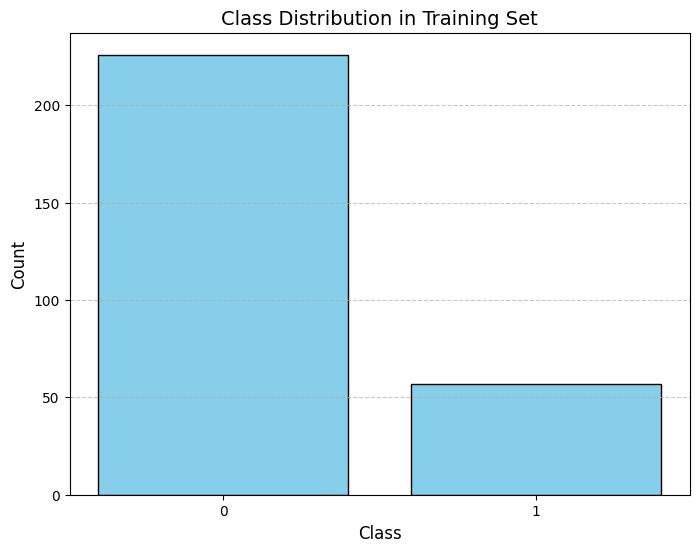

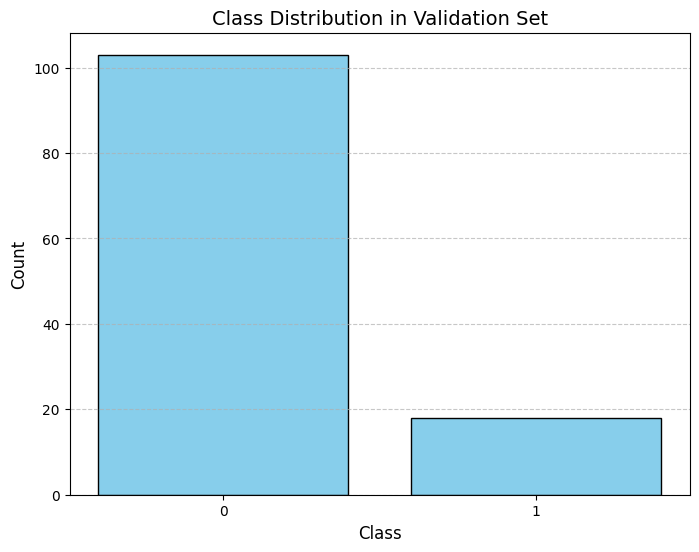

Training Set Distribution: Counter({0: 226, 1: 57})
Validation Set Distribution: Counter({0: 103, 1: 18})


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(labels, dataset_name="Dataset"):
    """
    Plots the class distribution of the labels.
    :param labels: List or array-like containing class labels.
    :param dataset_name: Name of the dataset (e.g., "Training" or "Validation").
    """
    label_counts = Counter(labels)
    classes = list(label_counts.keys())
    counts = list(label_counts.values())
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.title(f"Class Distribution in {dataset_name}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(classes, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
# Assuming y_train and y_val are your training and validation labels
# Replace these with your actual label arrays or lists

_train_dataloader_one_batch = DataLoader(train_dataset, batch_size=1, shuffle=False)
_val_dataloader_one_batch = DataLoader(val_dataset, batch_size=1, shuffle=False)
# Extract labels from the dataset
all_train_labels = []

for _, label_tensor in _train_dataloader_one_batch:
    all_train_labels.append(label_tensor.item())

all_val_labels = []

for _, label_tensor in _val_dataloader_one_batch:
    all_val_labels.append(label_tensor.item())

# Plot distributions
plot_class_distribution(all_train_labels, dataset_name="Training Set")
plot_class_distribution(all_val_labels, dataset_name="Validation Set")

# Print exact distributions
print("Training Set Distribution:", Counter(all_train_labels))
print("Validation Set Distribution:", Counter(all_val_labels))


In [ ]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Validation loop
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation"):
            images, labels = batch
            # images = torch.cat([torch.stack(image) for image in images]).to(device)
            # labels = torch.cat(labels).to(device)

            images = images.to(device)
            labels = labels.to(device)
            # print(f"Images shape: {images.shape}, range: ({images.min()}, {images.max()})")
            # print(f"Labels shape: {labels.shape}, values: {labels.unique()}")
            outputs = model(pixel_values=images).logits

            # print(f"Outputs shape: {outputs.shape}, range: ({outputs.min()}, {outputs.max()})")
            # print(f"Labels shape: {labels.shape}, values: {labels.unique()}")
            
            loss = criterion(outputs, labels)
            # print(f"Loss value: {loss.item()}")

            if not torch.isfinite(loss):
                print("Warning: Non-finite loss detected")
                continue

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / len(data_loader), correct / total

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training"):
        images, labels = batch  # Get images and labels
        images = images.to(device)
        labels = labels.to(device)  

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits  # Get logits
        
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()
        
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(dataloader), correct / total

# Training and Validation
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation: 100%|██████████| 8/8 [00:00<00:00, 10.67it/s]


Epoch 1/10
Train Loss: 0.6854, Train Accuracy: 0.5795
Validation Loss: 0.5977, Validation Accuracy: 0.6860


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s]


Epoch 2/10
Train Loss: 0.5395, Train Accuracy: 0.7420
Validation Loss: 0.5310, Validation Accuracy: 0.8264


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


Epoch 3/10
Train Loss: 0.5329, Train Accuracy: 0.7633
Validation Loss: 0.5197, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Epoch 4/10
Train Loss: 0.5421, Train Accuracy: 0.7774
Validation Loss: 0.5190, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.52it/s]


Epoch 5/10
Train Loss: 0.5454, Train Accuracy: 0.7809
Validation Loss: 0.5188, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


Epoch 6/10
Train Loss: 0.5448, Train Accuracy: 0.7809
Validation Loss: 0.5186, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


Epoch 7/10
Train Loss: 0.5430, Train Accuracy: 0.7809
Validation Loss: 0.5185, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


Epoch 8/10
Train Loss: 0.5410, Train Accuracy: 0.7809
Validation Loss: 0.5184, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.10it/s]


Epoch 9/10
Train Loss: 0.5391, Train Accuracy: 0.7809
Validation Loss: 0.5183, Validation Accuracy: 0.8347


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]

Epoch 10/10
Train Loss: 0.5372, Train Accuracy: 0.7809
Validation Loss: 0.5182, Validation Accuracy: 0.8347


In [ ]:
# Testing
def test(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images).logits
            _, predicted = outputs.max(1)

            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return predictions, true_labels

predictions, true_labels = test(model, test_loader, DEVICE)

# Evaluate test results
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions, target_names=["non-cloud_hole", "cloud_hole"]))


Testing: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


                precision    recall  f1-score   support

non-cloud_hole       0.54      0.94      0.69        51
    cloud_hole       0.00      0.00      0.00        41

      accuracy                           0.52        92
     macro avg       0.27      0.47      0.34        92
  weighted avg       0.30      0.52      0.38        92



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForImageClassification

class ModifiedResNet18(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(ModifiedResNet18, self).__init__()
        self.resnet = pretrained_model
        self.resnet.fc = nn.Identity()

        # Determine feature dimension dynamically
        dummy_input = torch.randn(1, 3, 224, 224)  # Example input: batch_size=1, channels=3, height=224, width=224
        with torch.no_grad():
            dummy_output = self.resnet(dummy_input)
        feature_dim = dummy_output.logits.shape[-1]

        self.classifier = nn.Linear(feature_dim, num_classes)


    def forward(self, x):
        x = self.resnet(x)
        x = x.logits
        x = self.classifier(x)
        return x

# Load pretrained ResNet-18 model
model_name = "microsoft/resnet-18"
model = AutoModelForImageClassification.from_pretrained(model_name)
model = ModifiedResNet18(model, num_classes=2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):
    model.train()
    for inputs, labels in train_loader:
        inputs = [inp.to(device) for inp in inputs]
        labels = labels.to(device)

        optimizer.zero_grad()
        for i in range(len(inputs)):
            if inputs[i].size(1) == 1:
                inputs[i] = inputs[i].repeat(1, 3, 1, 1)
            outputs = model(inputs[i])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = [inp.to(device) for inp in inputs]
        labels = labels.to(device)

        for i in range(len(inputs)):
            if inputs[i].size(1) == 1:
                inputs[i] = inputs[i].repeat(1, 3, 1, 1)
            outputs = model(inputs[i])
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
# Check shapes of inputs and labels in train_loader and test_loader

# Checking train_loader
print("Checking train_loader shapes:")
for inputs, labels in train_loader:
    print(f"Train - Inputs shape: {inputs[0].shape}, Labels shape: {labels.shape}")
    break  # Only check the first batch

# Checking test_loader
print("Checking test_loader shapes:")
for inputs, labels in test_loader:
    print(f"Test - Inputs shape: {inputs[0].shape}, Labels shape: {labels.shape}")
    break  # Only check the first batch
